<a href="https://colab.research.google.com/github/soesantanu/soesantanu.github.io/blob/main/Image_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import builtins
import numpy as np
from numpy.linalg import norm
from skimage import io, color
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

In [ ]:
# =========================================================
# Operators: forward gradient and its adjoint (divergence)
# =========================================================
def nabla(x):
    """Forward differences"""
    H, W = x.shape
    G = np.zeros((H, W, 2), dtype=x.dtype)
    G[:, :-1, 0] = x[:, 1:] - x[:, :-1]   # horizontal
    G[:-1, :, 1] = x[1:, :] - x[:-1, :]   # vertical
    return G

def nablaT(G):
    """Adjoint of nabla (negative divergence): (H,W,2) -> (H,W)."""
    H, W = G.shape[:2]
    y = np.zeros((H, W), dtype=G.dtype)
    # horizontal
    y[:, :-1] -= G[:, :-1, 0]
    y[:,  1:] += G[:, :-1, 0]
    # vertical
    y[:-1, :] -= G[:-1, :, 1]
    y[ 1:, :] += G[:-1, :, 1]
    return y

# =========================================================
# Pixelwise L_2 norm and projection onto L_2-ball
# =========================================================
def pixel_l2_norm(G):
    return np.sqrt((G*G).sum(axis=-1))

def proj_ball_l2(P, r):
    if r <= 0:
        return np.zeros_like(P)
    nrm   = pixel_l2_norm(P)
    scale = np.maximum(1.0, nrm/r)
    return P/scale[...,None]

def prox_g_conj(q, lam_tv):
    return proj_ball_l2(q, lam_tv)

# =========================================================
# Smooth part h and its gradient (MASK ONLY HERE)
#   h(x) = (1/2) * || M * (x - b) ||^2
#   nabla h(x) = M * (x - b)
# =========================================================
def grad_h(x, b, mask):
    return mask * (x - b)
# =========================================================
# Energy monitor:
#   F(x) = 0.5 * || M * (x - b) ||^2 + lam_tv * \|Dx\|_{2,1}
# =========================================================
def energy_tvL2(x, b, mask, lam_tv):
    data_term = 0.5 * np.sum((mask * (x - b))**2)
    tv_term   = lam_tv * np.sum(pixel_l2_norm(nabla(x)))
    return data_term + tv_term

In [ ]:
# =========================================================
# Adaptive Golden-Ratio Primal–Dual Algorithm (records F and PSNR)
#   min f(x)+g(Kx)+h(x) with f≡0, g(u)=lam_tv||u||_{2,1}, K=nabla, h(x)=(1/2)||M*(x-b)||^2
# =========================================================
def pd_adaptive_golden_inpaint(
    J, K, K_T, norm_K_sq,
    x0, y0,
    b, mask,
    lam_tv,
    tau0, phi, beta, tau_max, rho_val,
    num_iter=1000, tol=1e-16,
    psnr_ref=None,  # ground truth for PSNR
    verbose=True
):
    """
    Adaptive GRPDA.
    """
    t0 = time.perf_counter()

    x = x0.copy(); y = y0.copy(); z = x.copy()
    tau_prev = tau0
    theta_prev = 1.0

    values, taus, sigmas, times = [], [], [], []
    psnrs = []

    # Initial datas
    values.append(J(x, y))
    if psnr_ref is not None:
        dr = float(psnr_ref.max() - psnr_ref.min())
        psnrs.append(psnr(psnr_ref, x, data_range=dr))
    times.append(time.perf_counter() - t0)

    for it in range(num_iter):
        # Inertial step: z_{n+1} = x - (1 / phi) * (x - z)
        z = x - (1 / phi) * (x - z)

        # Primal gradient step (f = 0)
        grad_h_x = grad_h(x, b, mask)
        x1 = z - tau_prev * (K_T(y) + grad_h_x)

        # calculate x_nrm and dhx_nrm
        dx      = x1 - x
        dh_diff = grad_h(x1, b, mask) - grad_h(x, b, mask)
        dx_norm_sq      = float(np.sum(dx*dx, dtype=np.float64))
        dh_diff_norm_sq = float(np.sum(dh_diff*dh_diff, dtype=np.float64))

        if dh_diff_norm_sq != 0.0:
            L_bar_prev = dh_diff_norm_sq / dx_norm_sq
            L_current1 = (phi * theta_prev) / (9.0 * tau_prev)  # theta_prev ≡ 1.0
            L_n        = L_current1 / (L_bar_prev + phi * beta * norm_K_sq)
            tau_n      = builtins.min(rho_val * tau_prev, L_n, tau_max)
        else:
            tau_n = builtins.min(rho_val * tau_prev, tau_max)

        sigma_n = beta * tau_n

        # Dual prox step (projection radius = lam_tv)
        y1 = prox_g_conj(y + sigma_n * K(x1), lam_tv)

        # Update
        theta_n = phi * (tau_n / tau_prev)
        x, y = x1, y1
        tau_prev, theta_prev = tau_n, theta_n

        val = J(x, y)
        values.append(val)
        taus.append(tau_n); sigmas.append(sigma_n)
        times.append(time.perf_counter() - t0)
        if psnr_ref is not None:
            psnrs.append(psnr(psnr_ref, x, data_range=dr))

        if verbose:
            print(f"[Full-Adapt] It {it+1:4d}: F={val:.30e} |tau={tau_n:.3e} sigma={sigma_n:.3e} "
                  f"| ||dx||={np.sqrt(dx_norm_sq):.3e} ||d nablah||={np.sqrt(dh_diff_norm_sq):.3e}")

        if val <= tol:
            if verbose:
                print(f"[Full-Adapt] Converged at it {it+1}. Time={times[-1]:.2f}s")
            break
    else:
        if verbose:
            print(f"[Full-Adapt] Max iters. Final F={values[-1]:.6e}, Time={times[-1]:.2f}s")

    return {'x': x, 'y': y, 'values': values, 'psnrs': psnrs,
            'taus': taus, 'sigmas': sigmas, 'times': times}

In [ ]:
# =========================================================
# Golden-Ratio PD with PARTIAL adaptive step-size (operator form)
# =========================================================
def pd_golden_partial_adaptive_inpaint(
    J, K, K_T,
    x0, y0,
    b, mask,
    lam_tv,
    tau0, phi, beta,
    mu, mu1,                 # choose μ > 2 μ1 per your note
    num_iter=1000, tol=1e-16,
    psnr_ref=None,
    verbose=True
):
    t0 = time.perf_counter()

    x = x0.copy(); y = y0.copy(); z = x.copy()
    tau_prev = tau0

    values, taus, sigmas, times, psnrs = [], [], [], [], []

    # Initial monitor
    values.append(J(x, y))
    if psnr_ref is not None:
        dr = float(psnr_ref.max() - psnr_ref.min())
        psnrs.append(psnr(psnr_ref, x, data_range=dr))
    times.append(time.perf_counter() - t0)

    for it in range(num_iter):
        # Inertial step: z_{n+1} = z + (x - z)/phi
        z = x - (1 / phi) * (x - z)

        # Primal update
        grad_h_x = grad_h(x, b, mask)
        x1 = z - tau_prev * (K_T(y) + grad_h_x)

        # Partial-adaptive steps
        dx      = x1 - x
        dKx     = K(x1) - K(x)
        dh_diff = grad_h(x1, b, mask) - grad_h(x, b, mask)

        Kx_norm  = float(np.sum(dKx*dKx, dtype=np.float64))
        x_norm      = float(np.sum(dx*dx, dtype=np.float64))
        dhx_norm = float(np.sum(dh_diff*dh_diff, dtype=np.float64))

        if Kx_norm != 0 and dhx_norm != 0:
            tau_n = builtins.min(tau_prev, (mu / np.sqrt(beta)) * (x_norm / Kx_norm), mu1 * (x_norm / dhx_norm)) # mu should be greater than 2*mu1
        elif Kx_norm != 0 and dhx_norm == 0:
            tau_n = min(tau_prev, (mu / np.sqrt(beta)) * (x_norm / Kx_norm))
        elif Kx_norm == 0 and dhx_norm != 0:
            tau_n = min(tau_prev, mu1 * (x_norm / dhx_norm))
        else:
            tau_n = tau_prev

        sigma_n = beta * tau_n

        # Dual update
        y1 = prox_g_conj(y + sigma_n * K(x1), lam_tv)

        # Book-keeping
        x, y = x1, y1
        tau_prev = tau_n

        val = J(x, y)
        values.append(val)
        taus.append(tau_n); sigmas.append(sigma_n)
        times.append(time.perf_counter() - t0)
        if psnr_ref is not None:
            psnrs.append(psnr(psnr_ref, x, data_range=dr))

        if verbose:
            print(f"[Partial] It {it+1:4d}: F={val:.30e} |tau={tau_n:.3e} sigma={sigma_n:.3e} "
                  f"| ||dx||={x_norm:.3e} ||dKx||={Kx_norm:.3e} ||d nablah||={dhx_norm:.3e}")

        if val <= tol:
            if verbose:
                print(f"[Partial] Converged at it {it+1}. Time={times[-1]:.2f}s")
            break
    else:
        if verbose:
            print(f"[Partial] Max iters. Final F={values[-1]:.6e}, Time={times[-1]:.2f}s")

    return {'x': x, 'y': y, 'values': values, 'psnrs': psnrs,
            'taus': taus, 'sigmas': sigmas, 'times': times}

In [ ]:
# =========================================================
# Fixed-steps Golden-Ratio PD (your pd_Golden, adapted correctly)
# =========================================================
def pd_Golden(
    J, K, K_T,
    x0, y0,
    b, mask,
    lam_tv,
    sigma, tau,
    phi,
    numb_iter=1000, tol=1e-16,
    psnr_ref=None,
    verbose=True
):
    t0 = time.perf_counter()

    x = x0.copy(); y = y0.copy(); z = x0.copy()
    values, taus, sigmas, times, psnrs = [], [], [], [], []

    # Initial monitor
    values.append(J(x, y))
    if psnr_ref is not None:
        dr = float(psnr_ref.max() - psnr_ref.min())
        psnrs.append(psnr(psnr_ref, x, data_range=dr))
    times.append(time.perf_counter() - t0)

    for i in range(numb_iter):
        # Inertial step
        z = x - (1.0 / phi) * (x - z)

        # Primal update
        grad_h_x = grad_h(x, b, mask)
        x = z - tau * (K_T(y) + grad_h_x)

        # Dual update
        y = prox_g_conj(y + sigma * K(x), lam_tv)

        val = J(x, y)
        values.append(val)
        taus.append(tau)
        sigmas.append(sigma)
        times.append(time.perf_counter() - t0)
        if psnr_ref is not None:
            psnrs.append(psnr(psnr_ref, x, data_range=dr))

        if verbose:
            print(f"[Fixed]     Iter {i+1:4d}: F={val:.30e} |tau={tau:.3e} sigma={sigma:.3e} phi={phi}")

        if val <= tol:
            if verbose:
                print(f"[Fixed]     Converged at iter {i+1} (F leq {tol}). Time={times[-1]:.2f}s")
            break
    else:
        if verbose:
            print(f"[Fixed]     Max iters ({numb_iter}). Final F={values[-1]:.6e}, Time={times[-1]:.2f}s")

    return [values, x, y, times, sigmas, taus, psnrs]

In [ ]:
def pd_primal_dual(J, K, K_T, x0, y0, b, mask, lam_tv,tau,
                   sigma, num_iter=100, tol=1e-16, psnr_ref=None, verbose=True):

    t0 = time.perf_counter()

    x = x0.copy()
    y = y0.copy()
    z = x.copy()
    theta = 1.0

    values, taus, sigmas, times = [], [], [], []
    psnrs = []

    # Initial records
    values.append(J(x, y))
    times.append(0.0)
    if psnr_ref is not None:
        dr = float(psnr_ref.max() - psnr_ref.min())
        psnrs.append(psnr(psnr_ref, x, data_range=dr))

    for it in range(num_iter):
        # Primal step
        gh = grad_h(x, b, mask)
        x1 = x - tau * K_T(y) - tau * gh

        # Inertial update
        z = x1 + theta * (x1 - x)

        # Dual step
        y1 = prox_g_conj(y + sigma * K(z), lam_tv)

        # Update iterates
        x, y = x1, y1

        # Record
        val = J(x, y)
        values.append(val)
        taus.append(tau)
        sigmas.append(sigma)
        times.append(time.perf_counter() - t0)
        if psnr_ref is not None:
            psnrs.append(psnr(psnr_ref, x, data_range=dr))

        if verbose:
            print(f"[PD] It {it+1:4d}: F={val:.30e} |tau={tau:.1e} sigma={sigma:.1e}")

        # Early stopping
        if val <= tol:
            if verbose:
                print(f"[PD] Converged at iteration {it+1}, time {times[-1]:.2f}s")
            break
    else:
        if verbose:
            print(f"[PD] Reached max iterations ({num_iter}); Final F={values[-1]:.3e}")

    return {
        'x': x, 'y': y,
        'values': values,
        'taus': taus,
        'sigmas': sigmas,
        'times': times,
        'psnrs': psnrs
    }

In [ ]:
# =========================================================
# --------Image loading and mask creation----------------
# =========================================================
img_path = '/content/cameraman.tiff' # Download the image from https://webpages.tuni.fi/foi/GCF-BM3D/.
img_ref = io.imread(img_path)

# Drop singleton dim if needed
if img_ref.ndim == 3 and img_ref.shape[0] == 1:
    img_ref = img_ref[0]

# Convert RGB => gray if needed
if img_ref.ndim == 3 and img_ref.shape[2] == 3:
    img_ref = color.rgb2gray(img_ref)

# Normalize to [0,1] float32
img_ref = img_ref.astype(np.float32)
if img_ref.max() > 1.0:
    img_ref /= 255.0

# Build mask and observed image b
h, w = img_ref.shape
mask = np.ones((h, w), dtype=np.float32)

removal_percentage = 0.3
num_pixels_to_remove = int(h * w * removal_percentage)
rand_idx = np.random.choice(h * w, num_pixels_to_remove, replace=False)
rows, cols = np.unravel_index(rand_idx, (h, w))
mask[rows, cols] = 0.0

b = img_ref * mask   # observed image (zeros on missing pixels)

# =========================================================
# ----------Run all-----------------
# =========================================================
lam_tv     = 1e-2      # TV weight (only on TV & proj radius)
phi        = 1.5
tau0       = 1
beta       = 0.1
tau_max    = 1e7
rho_val    = 1.0/phi + 1.0/(phi**2)
norm_K_sq  = 8.0       # ||K||^2 ≤ 8

x0 = b.copy()
y0 = nabla(x0) * 0.0
J  = lambda x, y: energy_tvL2(x, b, mask, lam_tv)
dr = float(img_ref.max() - img_ref.min())

# aEGRPDA
res_full = pd_adaptive_golden_inpaint(
    J=J,
    K=nabla,
    K_T=nablaT,
    norm_K_sq=norm_K_sq,
    x0=x0,
    y0=y0,
    b=b,
    mask=mask,
    lam_tv=lam_tv,
    tau0=tau0,
    phi=phi,
    beta=beta,
    tau_max=tau_max,
    rho_val=rho_val,
    num_iter=5000,
    tol=1e-16,
    psnr_ref=img_ref,
    verbose=True
)

# Partial-adaptive GRPDA (P-GRPDA)
mu, mu1    = 0.79, 0.266
phi2, beta1 = 1.70, 0.1
tau_pgrpda = 1
res_part = pd_golden_partial_adaptive_inpaint(
    J=J,
    K=nabla,
    K_T=nablaT,
    x0=x0,
    y0=y0,
    b=b,
    mask=mask,
    lam_tv=lam_tv,
    tau0=tau_pgrpda,
    phi=phi2,
    beta=beta,
    mu=mu,
    mu1=mu1,
    num_iter=5000,
    tol=1e-16,
    psnr_ref=img_ref,
    verbose=True
)

# GRPDA with fixed steps
tau_fixed   = 4e-2
sigma_fixed = 1e-2
phi2        = (1 + np.sqrt(5)) / 2
res_fix = pd_Golden(
    J=J,
    K=nabla,
    K_T=nablaT,
    x0=x0,
    y0=y0,
    b=b,
    mask=mask,
    lam_tv=lam_tv,
    sigma=sigma_fixed,
    tau=tau_fixed,
    phi = phi2,
    numb_iter=5000,
    tol=1e-16,
    psnr_ref=img_ref,
    verbose=True
)

# Fixed-steps Condat–Vu
tau_cv   = 4e-2
sigma_cv = 10e-2
res_cv = pd_primal_dual(
    J=J,
    K=nabla,
    K_T=nablaT,
    x0=x0,
    y0=y0,
    b=b,
    mask=mask,
    lam_tv=lam_tv,
    tau=tau_cv,
    sigma=sigma_cv,
    num_iter=5000,
    tol=1e-16,
    psnr_ref=img_ref,
    verbose=True
)


Streaming output truncated to the last 5000 lines.
[PD] It    2: F=2.314797668457031250000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It    3: F=2.306539001464843750000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It    4: F=2.298317108154296875000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It    5: F=2.290250244140625000000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It    6: F=2.282375183105468750000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It    7: F=2.274715728759765625000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It    8: F=2.267286376953125000000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It    9: F=2.260092773437500000000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It   10: F=2.253134002685546875000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It   11: F=2.246409301757812500000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It   12: F=2.239913635253906250000000000000e+02 |tau=4.0e-02 sigma=1.0e-01
[PD] It   13: F=2.233639068603515625000000000000e+02 |tau=4.0e-02 sig

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

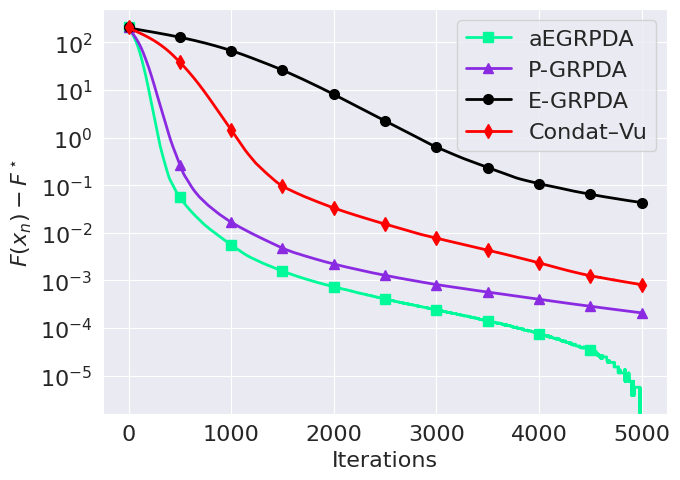

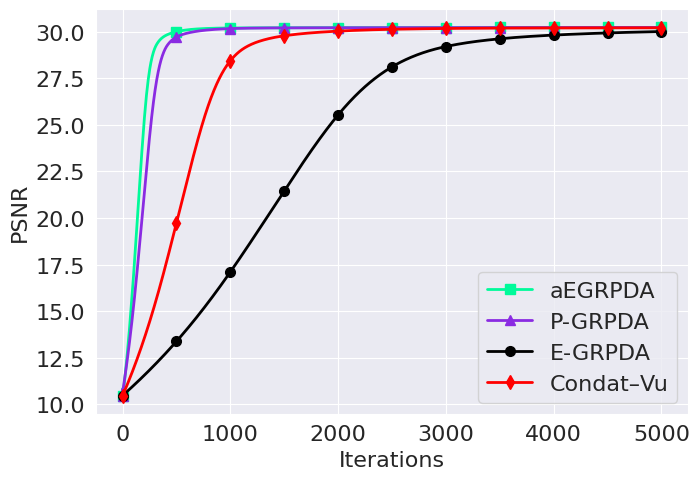

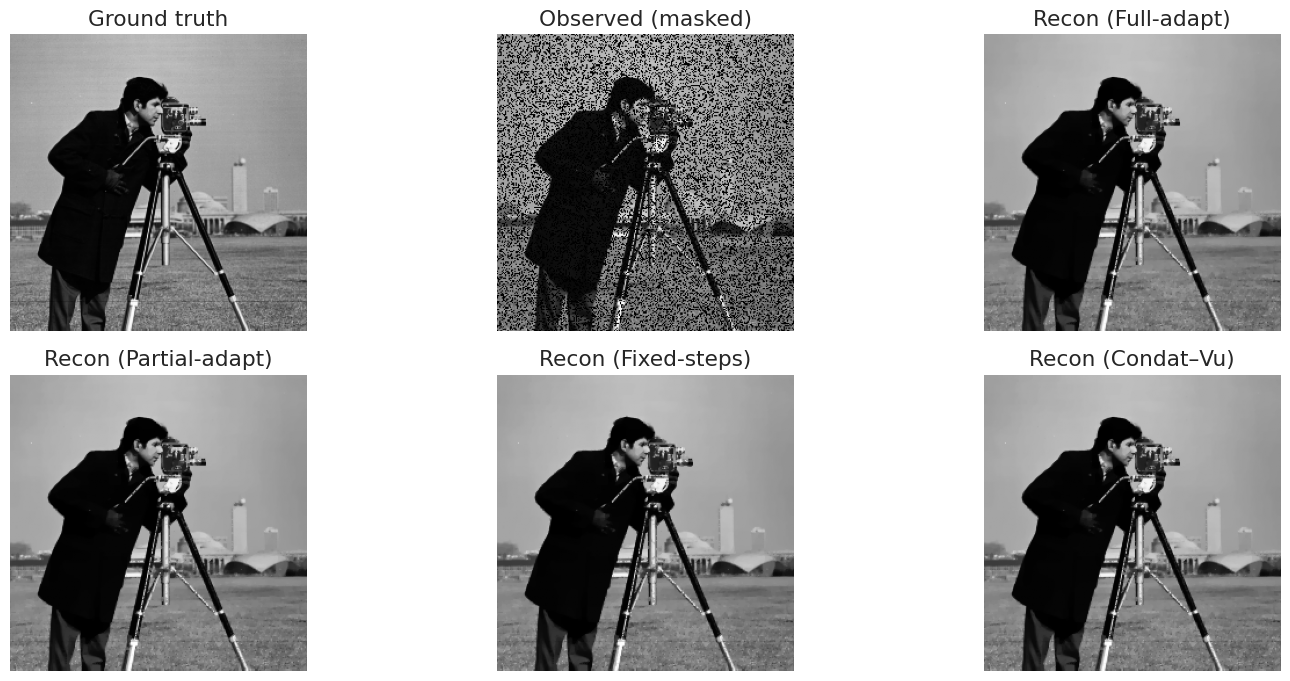

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ——— 1) Set seaborn style ———
sns.set_style('darkgrid')
plt.rcParams['legend.facecolor'] = plt.rcParams['axes.facecolor']

# ——— 2) Update Matplotlib parameters ———
plt.rcParams.update({
    'font.size':        13,
    'figure.figsize':   (7, 5),
    'legend.fontsize':  16,
    'lines.linewidth':  2,
    'axes.labelsize':   16,
    'xtick.labelsize':  16,
    'ytick.labelsize':  16,
    'xtick.major.pad':  4,
    'ytick.major.pad':  4,
})

# =========================================================
# ---- Extract results & compute gaps ----
# =========================================================
# Primal–dual runs
x_full = res_full['x']
x_part = res_part['x']
x_fix  = res_fix[1]     # assume res_fix uses dict with key 'x'
x_cv   = res_cv['x']

# Objective values
vals_full = np.array(res_full['values'])
vals_part = np.array(res_part['values'])
vals_fix  = np.array(res_fix[0])
vals_cv   = np.array(res_cv['values'])

# PSNR curves
psnrs_full = np.array(res_full['psnrs'])
psnrs_part = np.array(res_part['psnrs'])
psnrs_fix  = np.array(res_fix[-1])
psnrs_cv   = np.array(res_cv['psnrs'])

# Common F* for all methods
F_star = min(vals_full.min(), vals_part.min(), vals_fix.min(), vals_cv.min())

# Energy gaps
gap_full = vals_full - F_star
gap_part = vals_part - F_star
gap_fix  = vals_fix  - F_star
gap_cv   = vals_cv   - F_star

# Iteration indices
iters_full = np.arange(len(vals_full))
iters_part = np.arange(len(vals_part))
iters_fix  = np.arange(len(vals_fix))
iters_cv   = np.arange(len(vals_cv))

# =========================================================
# ---- Residual plot (l----
# =========================================================
energy_defs = [
    (iters_full, gap_full, 'aEGRPDA', 's', '#00FA9A'),
    (iters_part, gap_part, 'P-GRPDA', '^', '#8A2BE2'),
    (iters_fix,  gap_fix,  'E-GRPDA', 'o', 'black'),
    (iters_cv,   gap_cv,   'Condat–Vu', 'd', 'red'),
]

plt.figure(figsize=(7,5))
for x, y, lbl, mk, col in energy_defs:
    me = max(1, len(x)//10)
    plt.plot(x, y,
             color=col,
             marker=mk,
             markersize=7,
             markevery=me,
             label=lbl)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r'$F(x_n)-F^\star$')
plt.legend()
plt.tight_layout()
plt.savefig('gap_vs_iterations.eps', dpi=600)
files.download('gap_vs_iterations.eps')
plt.show()

# =========================================================
# ---- PSNR vs iterations plot ----
# =========================================================
psnr_defs = [
    (iters_full, psnrs_full, 'aEGRPDA', 's', '#00FA9A'),
    (iters_part, psnrs_part, 'P-GRPDA', '^', '#8A2BE2'),
    (iters_fix,  psnrs_fix,  'E-GRPDA', 'o', 'black'),
    (iters_cv,   psnrs_cv,   'Condat–Vu',      'd', 'red'),
]

plt.figure(figsize=(7,5))
for x, y, lbl, mk, col in psnr_defs:
    me = max(1, len(x)//10)
    plt.plot(x, y,
             color=col,
             marker=mk,
             markersize=7,
             markevery=me,
             label=lbl)
plt.xlabel('Iterations')
plt.ylabel('PSNR')
plt.legend()
plt.tight_layout()
# plt.savefig('psnr_vs_iterations.eps', dpi=600)
# files.download('psnr_vs_iterations.eps')
plt.show()

# =========================================================
# ---- Reconstructions comparison ----
# =========================================================
plt.figure(figsize=(16,7))
plt.subplot(2,3,1)
plt.imshow(img_ref, cmap='gray')
plt.title('Ground truth')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(b, cmap='gray')
plt.title('Observed (masked)')
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(x_full, cmap='gray')
plt.title('Recon (Full-adapt)')
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(x_part, cmap='gray')
plt.title('Recon (Partial-adapt)')
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(x_fix, cmap='gray')
plt.title('Recon (Fixed-steps)')
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(x_cv, cmap='gray')
plt.title('Recon (Condat–Vu)')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from matplotlib import pyplot as plt
from IPython.display import FileLink, display

def save_and_link(filename, img):
    plt.imsave(filename, img, cmap='gray', vmin=0, vmax=1)
    try:
        # Colab download
        from google.colab import files
        files.download(filename)
    except ImportError:
        # Jupyter link fallback
        display(FileLink(filename))

# Save & download/link each recovered image:
save_and_link('aEGRPDA_lam_.03.eps',  x_full)  # aEGRPDA
save_and_link('P_GRPDA_lam_.03.eps', x_part)  # P-GRPDA
save_and_link('GRPDA_lam_.03.eps',  x_fix)   #GRPDA
save_and_link('Condat_Vu_lam_.03.eps',     x_cv)    # Condat–Vu
# save_and_link('recon_ground_truth.eps', img_ref) # True Image
# save_and_link('recon_observed.eps',     b)       # Observed image


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>